# Testing `interpret` module

**Authorship:**
Adam Klie, *03/19/2022*
***
**Description:**
Notebook for testing the `interpret` module of the `eugene` package.

In [1]:
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

In [2]:
import eugene as eu

Global seed set to 13


# Load data

In [ ]:
sdata = eu.datasets.random1000()
eu.pp.prepare_data(sdata)
sdata

Kept 1000 sequences with targets, dropped 0 sequences with no targets


  0%|          | 0/3 [00:00<?, ?it/s]

SeqData object modified:
	rev_seqs: None -> 1000 rev_seqs added
	ohe_seqs: None -> 1000 ohe_seqs added
    seqs_annot:
        + TRAIN


SeqData object with = 1000 seqs
seqs = (1000,)
names = (1000,)
rev_seqs = (1000,)
ohe_seqs = (1000, 66, 4)
ohe_rev_seqs = None
seqs_annot: 'TARGETS', 'TRAIN'
pos_annot: PyRanges object with 1400 features

In [ ]:
sdataset = sdata.to_dataset(label="TARGETS", seq_transforms=["one_hot_encode"], transform_kwargs={"transpose": True})
sdataloader = DataLoader(sdataset, batch_size=32, num_workers=0)

# Instantiate EUGENE architecture

In [ ]:
CNN_KWARGS=dict(channels=[4, 16, 32], conv_kernels=[15, 5], pool_kernels=[1, 1])
RNN_KWARGS=dict(output_dim=32, bidirectional=True, batch_first=True)
FCN_KWARGS=dict(hidden_dims=[50])
MODEL = "hybrid"
STRAND = "ss"
TASK = "regression"

In [ ]:
eugene = eu.models.Hybrid(input_len=66, output_dim=1, strand=STRAND, task=TASK, conv_kwargs=CNN_KWARGS, rnn_kwargs=RNN_KWARGS, fc_kwargs=FCN_KWARGS)
#eugene = eu.models.DeepBind(input_len=66, output_dim=1, strand=STRAND, task=TASK)
eu.models.base.init_weights(eugene)
eugene

Hybrid(
  (r_squared): R2Score()
  (convnet): BasicConv1D(
    (module): Sequential(
      (0): Conv1d(4, 16, kernel_size=(15,), stride=(1,))
      (1): ReLU()
      (2): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
      (3): Conv1d(16, 32, kernel_size=(5,), stride=(1,))
      (4): ReLU()
      (5): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (recurrentnet): BasicRecurrent(
    (module): LSTM(32, 32, batch_first=True, bidirectional=True)
  )
  (fcnet): BasicFullyConnectedModule(
    (module): Sequential(
      (0): Linear(in_features=64, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=1, bias=True)
    )
  )
)

# Feature attribtion 

In [ ]:
_, x, x_rev, y = next(iter(sdataloader))
x.shape, x_rev.shape, y.shape

(torch.Size([32, 4, 66]), torch.Size([32, 4, 66]), torch.Size([32]))

In [ ]:
explains = eu.interpret.nn_explain(eugene, (x, x_rev), saliency_type="InputXGradient")
explains.shape

(32, 4, 66)

In [ ]:
explains = eu.interpret.nn_explain(eugene, (x, x_rev), saliency_type="NaiveISM")
explains.shape

(32, 4, 66)

In [ ]:
explains = eu.interpret.nn_explain(eugene, (x, x_rev), saliency_type="DeepLift")
explains.shape

(32, 4, 66)

In [ ]:
explains = eu.interpret.nn_explain(eugene, (x, x_rev), saliency_type="GradientShap")
explains.shape

In [41]:
eu.interpret.feature_attribution(eugene, sdata)
eu.interpret.feature_attribution(eugene, sdata, saliency_method="NaiveISM")
eu.interpret.feature_attribution(eugene, sdata, saliency_method="DeepLift") 

  0%|          | 0/31 [00:00<?, ?it/s]

Note: NaiveISM is not implemented yet for models other than single stranded ones


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

In [52]:
eu.interpret.feature_attribution(eugene, sdata, saliency_method="GradientShap")

[autoreload of eugene.interpret._feature_attribution failed: Traceback (most recent call last):
  File "/cellar/users/aklie/opt/miniconda3/envs/eugene/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/cellar/users/aklie/opt/miniconda3/envs/eugene/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/cellar/users/aklie/opt/miniconda3/envs/eugene/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/cellar/users/aklie/opt/miniconda3/envs/eugene/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/mnt/beegfs/users/aklie/projects/EUGENE/eugene/in

  0%|          | 0/31 [00:00<?, ?it/s]

UnboundLocalError: local variable 'attrs' referenced before assignment

In [42]:
sdata.uns.keys()

odict_keys(['InputXGradient_imps', 'NaiveISM_imps', 'DeepLift_imps'])

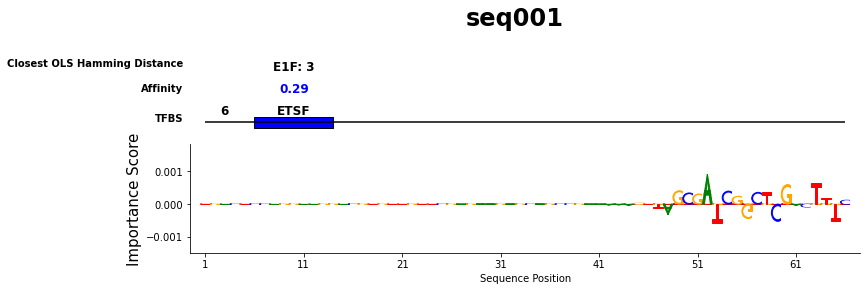

In [46]:
eu.pl.seq(sdata, seq_id="seq001", uns_key="DeepLift_imps")

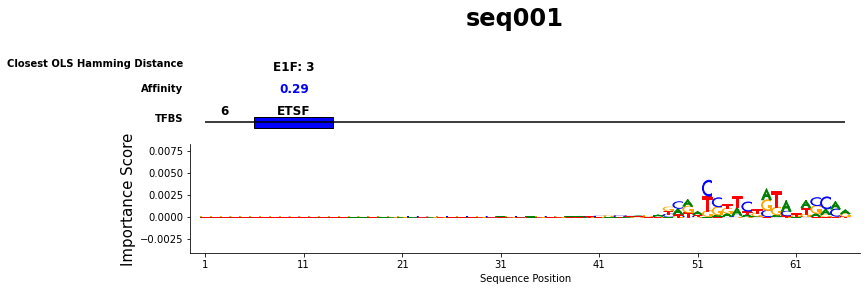

In [48]:
eu.pl.seq(sdata, seq_id="seq001", uns_key="NaiveISM_imps")

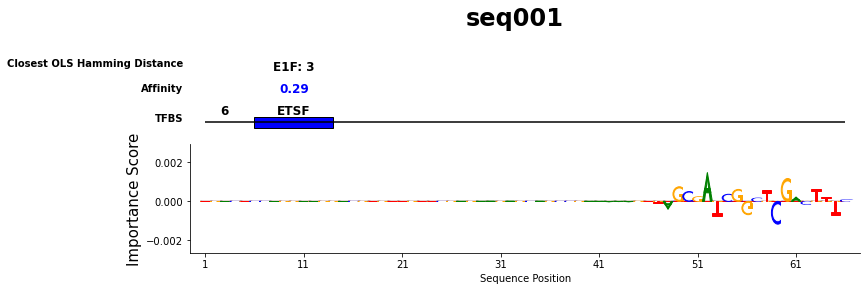

In [49]:
eu.pl.seq(sdata, seq_id="seq001", uns_key="InputXGradient_imps")

In [ ]:
eu.

# Filter vizualization 

In [12]:
eu.interpret.generate_pfms(eugene, sdata)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

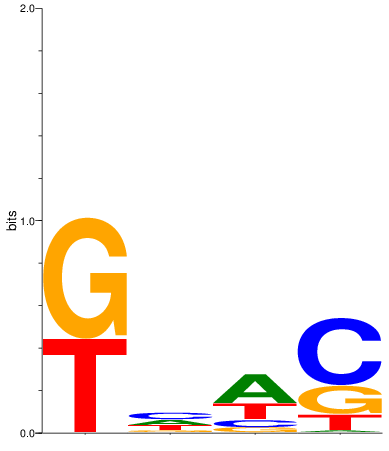

In [13]:
eu.pl.logo(sdata, filter_id=0, size="small")

# Feature attribution reduction

In [40]:
eu.interpret.pca(sdata, uns_key="InputXGradient_imps")

TypeError: pca() got an unexpected keyword argument 'uns_key'

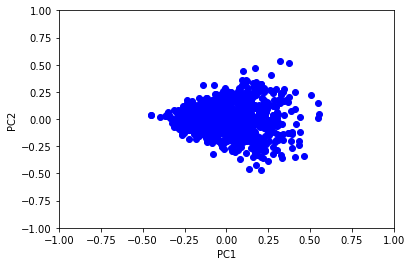

In [ ]:
eu.pl.pca(sdata, seqsm_key="InputXGradient_imps_pca")

In [ ]:
eu.interpret.umap(sdata, uns_key="InputXGradient_imps")

Make sure your matrix is sample by feature


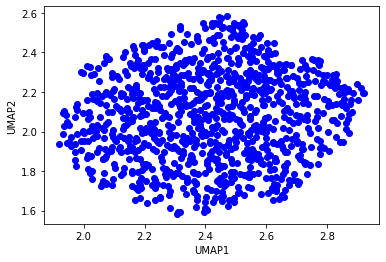

In [ ]:
eu.pl.umap(sdata, seqsm_key="InputXGradient_imps_umap")

# Scratch 

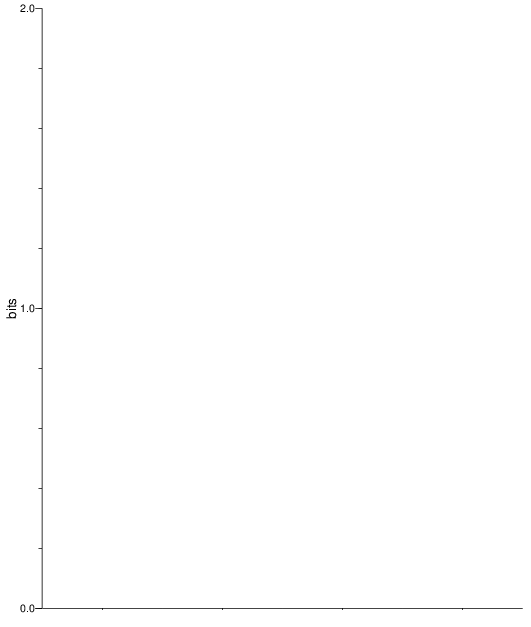

In [ ]:
eu.pl.plot_logo(seqlogo.Pwm(test.pwm))

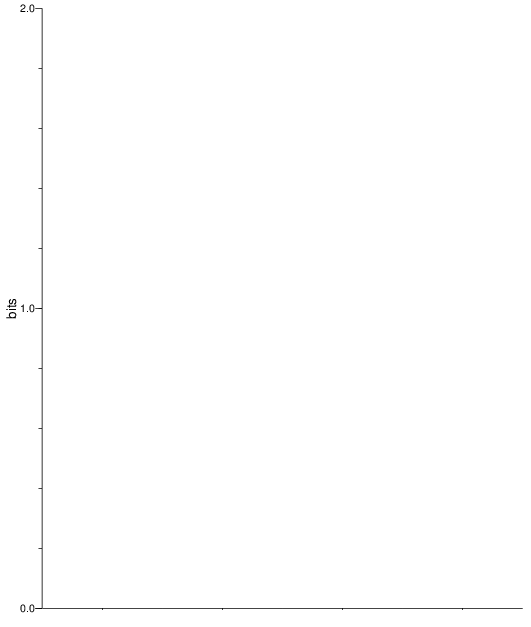

In [ ]:
eu.pl.plot_logo(seqlogo.CompletePm(seqlogo.pfm2pwm(test.pwm)))

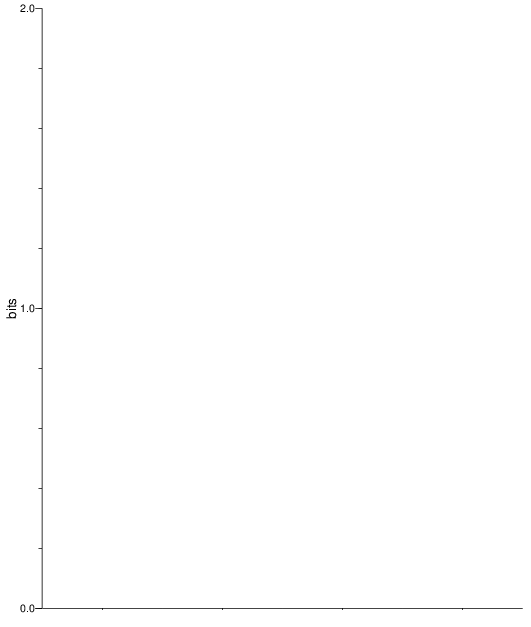

In [ ]:
eu.pl.plot_logo(seqlogo.CompletePm(test.pwm))

In [ ]:
eu.pl.plot_logo(test.pwm)

AttributeError: 'DataFrame' object has no attribute '_alphabet_type'

In [ ]:
test.pwm

,A,C,G,T
0,-31.219281,-31.219281,1.176816,0.798446
1,0.155128,0.462382,-1.189307,0.097814
2,0.993165,-0.938109,-1.377950,0.141133
3,-3.577362,1.239084,0.006536,-0.859352


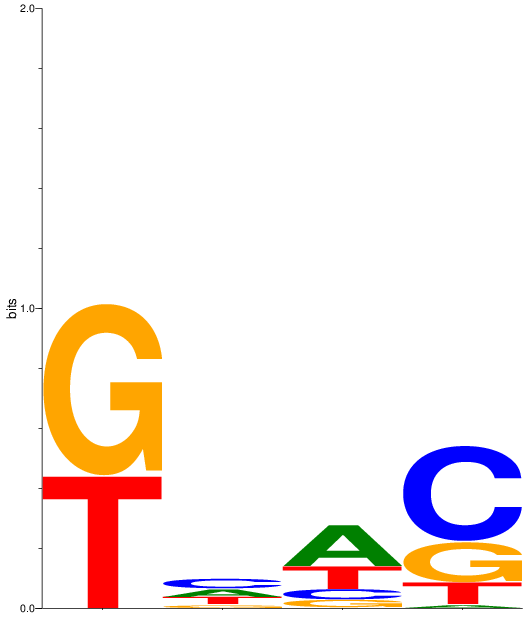

In [ ]:
eu.pl.plot_logo(cpms[0])

In [ ]:
from eugene.interpret._filters_to_pwms import _get_first_conv_layer, _get_activations_from_layer, _get_filter_activators, _get_pwms

In [ ]:
layer = _get_first_conv_layer(eugene)
acts, seqs = _get_activations_from_layer(layer, sdataloader)
activators = _get_filter_activators(acts, seqs, layer)
pwms = _get_pwms(activators, layer.kernel_size[0])

0it [00:00, ?it/s]

0 :  10791 0.8560847
1 :  4871 0.51075804
2 :  22152 0.6268455
3 :  9928 0.23927915
4 :  2189 0.4935101
5 :  7029 0.60175943
6 :  5643 0.73942125
7 :  5516 0.44271824
8 :  5394 0.5266361
9 :  5678 0.38835356
10 :  12754 0.7448571
11 :  27066 0.80411243
12 :  12252 0.8845444
13 :  8503 0.56819844
14 :  24998 0.8837944
15 :  22720 0.5602239


0it [00:00, ?it/s]

In [ ]:
pwms.pwm

,A,C,G,T
0,-31.219281,-31.219281,1.176816,0.798446
1,0.155128,0.462382,-1.189307,0.097814
2,0.993165,-0.938109,-1.377950,0.141133
3,-3.577362,1.239084,0.006536,-0.859352


In [ ]:
pwms = get_first_conv_layer(eugene)

In [ ]:
pwms.size()

torch.Size([32, 4, 15])

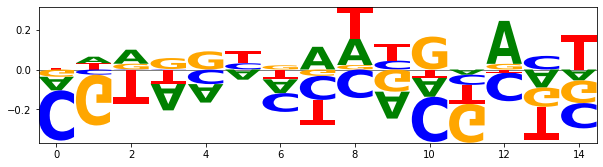

In [ ]:
for pwm in pwms:
    pwm_df = pd.DataFrame(columns=["A", "C", "G", "T"], data=pwm.T.detach().numpy())
    lm.Logo(pwm_df)
    break

In [ ]:
from eugene.interpret.nn_explain import nn_explain

In [ ]:
# Get access to the dataloader
mod.setup()
dataloader = mod.test_dataloader()
dataset = dataloader.dataset

In [ ]:
dataset_len = len(dataset)
example_shape = dataset[0][1].numpy().shape
all_explanations = np.zeros((dataset_len, *example_shape))
for i_batch, batch in enumerate(dataloader):
    ID, x, x_rev_comp, y = batch
    curr_explanations = nn_explain(eugene, (x, x_rev_comp), saliency_type="Saliency", device=device)
    if (i_batch+1)*BATCH_SIZE < dataset_len:
        print(i_batch*BATCH_SIZE, (i_batch+1)*BATCH_SIZE)
        all_explanations[i_batch*BATCH_SIZE: (i_batch+1)*BATCH_SIZE] = curr_explanations
    else:
        print(i_batch*BATCH_SIZE, dataset_len)
        all_explanations[i_batch*BATCH_SIZE:dataset_len] = curr_explanations

In [ ]:
from eugene.utils.otx_enhancer_utils import otxGenomeTracks

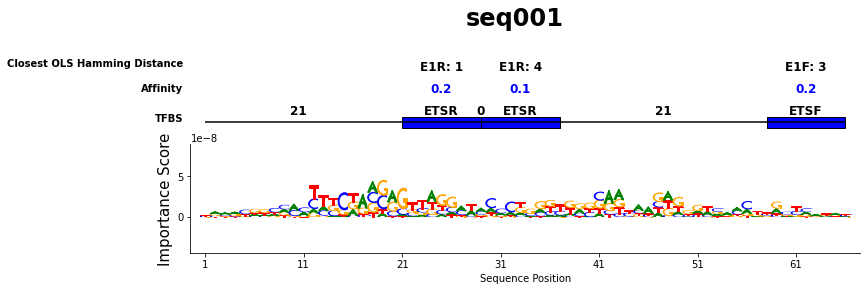

In [ ]:
# Visualize the first example
cmap = mpl.cm.RdYlGn
norm = mpl.colors.Normalize(vmin=0, vmax=1)
otxGenomeTracks(dataset.seqs[0], 
                importance_scores=all_explanations[0], 
                seq_name=dataset.names[0], 
                cmap=cmap, 
                norm=norm)

In [ ]:
from captum.attr import DeepLift
def deeplift_explain(model, inputs, ref_type="zero", target=None, device="cpu"):
    model.train()
    model.to(device)
    deep_lift = DeepLift(model)
    forward_inputs = inputs[0].requires_grad_().to(device)
    reverse_inputs = inputs[1].requires_grad_().to(device)
    if ref_type == "zero":
        forward_ref = torch.zeros(inputs[0].size()).to(device)
        reverse_ref = torch.zeros(inputs[1].size()).to(device)
    elif ref_type == "shuffle":
        forward_shuffled = forward_inputs.detach().to("cpu").squeeze(dim=0).numpy()
        forward_shuffled = reverse_inputs.detach().to("cpu").squeeze(dim=0).numpy()
        forward_ref = torch.tensor(dinuc_shuffle(forward_shuffled)).unsqueeze(dim=0).requires_grad_().to(device)
        reverse_ref = torch.tensor(dinuc_shuffle(reverse_ref)).unsqueeze(dim=0).requires_grad_().to(device)
    elif ref_type == "gc":
        ref = torch.tensor([0.3, 0.2, 0.2, 0.3]).expand(forward_inputs.size()[1], 4).unsqueeze(dim=0).to(device)
    attrs = deep_lift.attribute(inputs=forward_inputs, baselines=forward_ref, additional_forward_args=reverse_inputs)
    return attrs.to("cpu").detach().numpy()

In [ ]:
inputs = (dataset[0][1], dataset[0][1])
forward_inputs = inputs[0].requires_grad_().to(device)
reverse_inputs = inputs[1].requires_grad_().to(device)
dev_inputs = (forward_inputs, reverse_inputs)

In [ ]:
deeplift_explain(eugene, (dataset[:1024][1], dataset[:1024][2]), device=device)

ValueError: could not broadcast input array from shape (1024,37) into shape (1024,)

## Penultimate activations

## Repeat With Configs

## Load the config

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.utilities.cli import LightningArgumentParser
from pytorch_lightning.loggers import TensorBoardLogger

In [ ]:
parser = LightningArgumentParser()
parser.add_lightning_class_args(pl.Trainer, nested_key="trainer")
parser.add_lightning_class_args(SeqDataModule, nested_key="data")
parser.add_lightning_class_args(hybrid, nested_key="model");

In [ ]:
config = "/cellar/users/aklie/projects/EUGENE/config/data/2021_OLS_Library_Holdout_NPY-T_bin_clf.yaml"
yml = parser.parse_path(cfg_path=config)

## Use to load the data

In [ ]:
from eugene.dataloading.SeqDataModule import SeqDataModule

In [ ]:
mod = SeqDataModule(**yml["data"])
mod.setup()

## Load up the model from checkpoint

In [ ]:
from eugene.models.hybrid import hybrid

In [ ]:
CKT_PTH  = "/cellar/users/aklie/projects/EUGENE/results/simple/classification/sshybrid/2022_04_23_NPY_Baseline/checkpoints/epoch=25-step=4523.ckpt"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
eugene = hybrid.load_from_checkpoint(
    checkpoint_path=CKT_PTH,
    map_location=device,
)

/cellar/users/aklie/opt/miniconda3/envs/pytorch_dev/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [ ]:
from eugene.interpret.nn_explain import get_importances

In [ ]:
dataloader = mod.test_dataloader()
dataset = dataloader.dataset
imp = get_importances(eugene, dataloader, device=device, batch_size=yml["data"]["batch_size"])

In [ ]:
from eugene.utils.seq_utils import one_hot2string

In [ ]:
# Covert all the one hots to DNA sequence
seqs = one_hot2string(dataset.seqs, ["A", "C", "G", "T"])

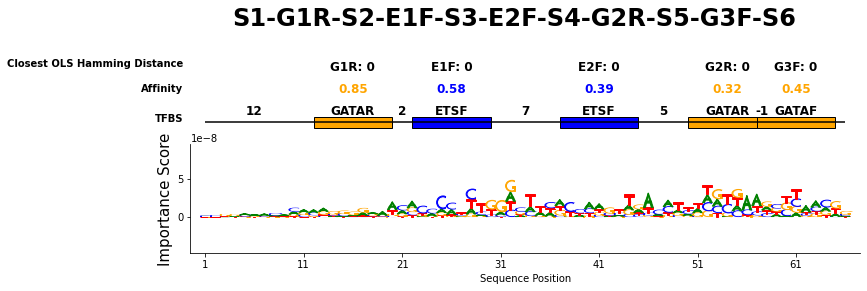

In [ ]:
# Show one
cmap = mpl.cm.RdYlGn
norm = mpl.colors.Normalize(vmin=0, vmax=1)
otxGenomeTracks(seqs[0], 
                importance_scores=imp[0], 
                seq_name=dataset.names[0], 
                cmap=cmap, 
                norm=norm)

In [ ]:
from eugene.utils.seq_utils import dinuc_shuffle
from eugene.utils.seq_utils import dinuc_content

In [ ]:
# Test example
forward = dataset[0][1]
reverse = dataset[0][2]
inputs = np.array([forward.numpy().T, reverse.numpy().T])
dna_seqs = one_hot2string(inputs, ["A", "C", "G", "T"])
shuffled_inputs = np.array([dinuc_shuffle(forward.numpy().T), dinuc_shuffle(reverse.numpy().T)])
shuffled_seqs = one_hot2string(shuffled_inputs, ["A", "C", "G", "T"])

In [ ]:
dinuc_content(dna_seqs[0]), dinuc_content(shuffled_seqs[0])

({'CA': 2,
  'AT': 6,
  'TC': 7,
  'CT': 6,
  'TG': 2,
  'GA': 6,
  'AA': 10,
  'AG': 5,
  'GC': 2,
  'CG': 3,
  'GT': 2,
  'TT': 5,
  'TA': 5,
  'AC': 1,
  'GG': 3},
 {'CG': 3,
  'GC': 2,
  'CA': 2,
  'AA': 10,
  'AT': 6,
  'TT': 5,
  'TC': 7,
  'CT': 6,
  'TA': 5,
  'AC': 1,
  'GA': 6,
  'AG': 5,
  'GT': 2,
  'GG': 3,
  'TG': 2})

In [ ]:
dinuc_content(dna_seqs[1]), dinuc_content(shuffled_seqs[1])

({'TC': 6,
  'CC': 3,
  'CT': 5,
  'TA': 5,
  'AT': 6,
  'TT': 10,
  'AG': 6,
  'GA': 7,
  'TG': 2,
  'GC': 2,
  'CA': 2,
  'AA': 5,
  'CG': 3,
  'AC': 2,
  'GT': 1},
 {'TT': 10,
  'TA': 5,
  'AG': 6,
  'GA': 7,
  'AA': 5,
  'AT': 6,
  'TC': 6,
  'CT': 5,
  'TG': 2,
  'GT': 1,
  'CC': 3,
  'CG': 3,
  'GC': 2,
  'CA': 2,
  'AC': 2})

In [ ]:
eugene.train()

hybrid(
  (convnet): BasicConv1D(
    (module): Sequential(
      (0): Conv1d(4, 32, kernel_size=(15,), stride=(1,))
      (1): ReLU(inplace=True)
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
      (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Conv1d(32, 64, kernel_size=(5,), stride=(1,))
      (6): ReLU(inplace=True)
      (7): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
      (8): Dropout(p=0.2, inplace=False)
      (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (recurrentnet): BasicRecurrent(
    (module): LSTM(64, 64, batch_first=True)
  )
  (fcnet): BasicFullyConnectedModule(
    (module): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.2, inplace=False)
      (3): BatchNorm1d(32, eps=1e-05, mo

In [ ]:
eugene.to(device)

hybrid(
  (convnet): BasicConv1D(
    (module): Sequential(
      (0): Conv1d(4, 32, kernel_size=(15,), stride=(1,))
      (1): ReLU(inplace=True)
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
      (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Conv1d(32, 64, kernel_size=(5,), stride=(1,))
      (6): ReLU(inplace=True)
      (7): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
      (8): Dropout(p=0.2, inplace=False)
      (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (recurrentnet): BasicRecurrent(
    (module): LSTM(64, 64, batch_first=True)
  )
  (fcnet): BasicFullyConnectedModule(
    (module): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.2, inplace=False)
      (3): BatchNorm1d(32, eps=1e-05, mo

In [ ]:
def load_from_pl_ckt(ckt_pth, model_type):
    if model_type in ["fcn", "cnn", "rnn"]:
        module = getattr(importlib.import_module(f"eugene.models.{model}"), model.upper())
    else:
        module = getattr(importlib.import_module(f"eugene.models.{model.lower}"), model.lower())
    model = hybrid.load_from_checkpoint(checkpoint_path=ckt_pth, map_location=device)
    return model

In [ ]:
model = "hybrid"

In [ ]:
import importlib

In [ ]:
module = getattr(importlib.import_module(f"eugene.models.{model.lower()}"), model.lower())

In [ ]:
ckt_pth = "/cellar/users/aklie/projects/EUGENE/results/simple/classification/sshybrid/2022_04_23_NPY_Baseline/checkpoints/epoch=25-step=4523.ckpt"

In [ ]:
module.load_from_checkpoint(checkpoint_path=ckt_pth, map_location="cuda")

/cellar/users/aklie/opt/miniconda3/envs/pytorch_dev/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


hybrid(
  (convnet): BasicConv1D(
    (module): Sequential(
      (0): Conv1d(4, 32, kernel_size=(15,), stride=(1,))
      (1): ReLU(inplace=True)
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
      (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Conv1d(32, 64, kernel_size=(5,), stride=(1,))
      (6): ReLU(inplace=True)
      (7): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
      (8): Dropout(p=0.2, inplace=False)
      (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (recurrentnet): BasicRecurrent(
    (module): LSTM(64, 64, batch_first=True)
  )
  (fcnet): BasicFullyConnectedModule(
    (module): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.2, inplace=False)
      (3): BatchNorm1d(32, eps=1e-05, mo